<a href="https://colab.research.google.com/github/S2H-Mobile/RoboND-DeepLearning-Project-Solution/blob/migrate-colab/code/model_training_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Follow-Me Project Model Training

This notebook is based on `model_training.ipynb` and the files in the `code/utils` folder.


In [0]:
from __future__ import absolute_import, division, print_function

import os
import imageio

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from glob import glob

from scipy import misc

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

tf.logging.set_verbosity(tf.logging.ERROR)

print(tf.VERSION)
print(tf.keras.__version__)

# Enable eager execution, for TensorFlow <2 only.
tf.enable_eager_execution()  

1.13.1
2.2.4-tf


# Download Data

Run these cells once in order to copy the training and evaluation data into the workspace.

In [0]:
# Download data for training, validation, and testing.
!mkdir ./data 
!curl -o ./data/train.zip https://s3-us-west-1.amazonaws.com/udacity-robotics/Deep+Learning+Data/Lab/train.zip
!curl -o ./data/validation.zip https://s3-us-west-1.amazonaws.com/udacity-robotics/Deep+Learning+Data/Lab/validation.zip
!curl -o ./data/eval.zip https://s3-us-west-1.amazonaws.com/udacity-robotics/Deep+Learning+Data/Project/sample_evaluation_data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52.9M  100 52.9M    0     0  25.1M      0  0:00:02  0:00:02 --:--:-- 25.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15.4M  100 15.4M    0     0  13.1M      0  0:00:01  0:00:01 --:--:-- 13.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.0M  100 13.0M    0     0  11.7M      0  0:00:01  0:00:01 --:--:-- 11.7M


In [0]:
# Unpack the downloaded archives to the data directory.
!unzip -q ./data/train.zip -d ./data
!unzip -q ./data/validation.zip -d ./data
!unzip -q ./data/eval.zip -d ./data
!mv ./data/train_combined ./data/train

# Build and Compile the Model

In [0]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = layers.SeparableConv2D(filters=filters,
                                          kernel_size=3,
                                          strides=strides,
                                          padding='same',
                                          activation='relu')(input_layer)
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters,
                                 kernel_size=kernel_size,
                                 strides=strides,
                                 padding='same',
                                 activation='relu')(input_layer)
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

In [0]:
def bilinear_upsample(input_layer, f=2):
    return layers.UpSampling2D(size=(f, f), data_format='channels_last', interpolation='bilinear')(input_layer)

In [0]:
def encoder_block(input_layer, filters, strides):
    return separable_conv2d_batchnorm(input_layer, filters, strides)

In [0]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer, f=2)
    
    # Concatenate the upsampled and large input layers using layers.concatenate
    concatenated_layer = layers.concatenate([upsampled_layer, large_ip_layer])
    
    # Add two separable convolution layers
    conv_layer_1 = separable_conv2d_batchnorm(concatenated_layer, filters)
    conv_layer_2 = separable_conv2d_batchnorm(conv_layer_1, filters)
    return conv_layer_2

In [0]:
def fcn_model(inputs, num_classes):
    
    # Add Encoder Blocks. The filter size increases with each encoder layer.
    layer_1 = encoder_block(inputs, filters=32, strides=2)
    layer_2 = encoder_block(layer_1, filters=64, strides=2)

    # Add 1x1 Convolution layer using conv2d_batchnorm().
    layer_3 = conv2d_batchnorm(layer_2, filters=128, kernel_size=1, strides=1)
    
    # Add the same number of decoder blocks as the number of encoder blocks.
    layer_4 = decoder_block(layer_3, layer_1, filters=64)
    layer_5 = decoder_block(layer_4, inputs, filters=32)
    
    # Add output Layer. Convolution operates on the final layer in last decoder block.
    output = layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(layer_5)
    
    # Return the output layer.
    return output

In [0]:
# Define the input layer.
image_shape = (160, 160, 3)
input_layer = layers.Input(image_shape)

# Define the output layer.
num_classes = 3
output_layer = fcn_model(input_layer, num_classes)

In [0]:
# Define the model.
model = models.Model(inputs=input_layer, outputs=output_layer)

# Print a summary of the model.
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 80, 80, 32)   155         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 80, 80, 32)   128         separable_conv2d[0][0]           
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 40, 40, 64)   2400        batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
batch_norm

In [0]:
# Compile the model for training.
learning_rate = 0.005

#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

model.compile(optimizer=tf.train.RMSPropOptimizer(learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])

# Data Preparation

In [0]:
preprocess_input = lambda x : (x/255.0 - 0.5) * 2.0

In [0]:
from tensorflow.keras.preprocessing.image import Iterator
from tensorflow.keras import backend as K

class BatchIteratorSimple(Iterator):
    def __init__(self, data_folder, batch_size, image_shape,
            num_classes=3, training=True, shuffle=True, seed=None):

        self.num_classes = num_classes
        self.data_folder = data_folder
        self.batch_size = batch_size
        self.training = training
        self.image_shape = tuple(image_shape)

        im_files = sorted(glob(os.path.join(data_folder, 'images', '*.jpeg')))
        mask_files = sorted(glob(os.path.join(data_folder, 'masks', '*.png')))

        if len(im_files) == 0:
            raise ValueError('No image files found, check your image diractories')

        if len(mask_files) == 0:
            raise ValueError('No mask files found, check your mask directories')

        self.file_tuples = list(zip(im_files, mask_files))
        self.n = len(self.file_tuples)

        super(BatchIteratorSimple, self).__init__(self.n, batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        """Gets a batch of transformed samples.

        # Arguments
            index_array: Array of sample indices to include in batch.

        # Returns
            A batch of transformed samples.
        """
        current_batch_size = len(index_array)       
        batch_x = np.zeros((current_batch_size,) + self.image_shape, dtype=K.floatx())

        if self.training:
            batch_y = np.zeros(
                    (current_batch_size,) + self.image_shape[:2] + (self.num_classes,),
                    dtype=K.floatx())

        for e, i in enumerate(index_array):
            # load labels of the person in focus
            file_tuple = self.file_tuples[i]
            image = imageio.imread(file_tuple[0])

            if image.shape != self.image_shape:
                image = misc.imresize(image, self.image_shape)

            if not self.training:
                image = preprocess_input(image.astype(np.float32))
                batch_x[e,:,:,:] = image
                continue
            else:
                gt_image = imageio.imread(file_tuple[1]).clip(0,1) 
                if gt_image.shape[0] != self.image_shape[0]:
                    gt_image = misc.imresize(gt_image, self.image_shape)
                image = preprocess_input(image.astype(np.float32))
                batch_x[e,:,:,:] = image
                batch_y[e,:,:,:] = gt_image

        if not self.training:
            return batch_x
        else:
            return batch_x, batch_y

## Batch Iteration

In [0]:
batch_size = 32

In [0]:
train_folder = os.path.join('data', 'train')
val_folder = os.path.join('data', 'validation')

# Iterator for batches of training data.
train_iter = BatchIteratorSimple(batch_size=batch_size,
                                 data_folder=train_folder,
                                 image_shape=image_shape)

# Iterator for batches of validation data.
val_iter = BatchIteratorSimple(batch_size=batch_size,
                               data_folder=val_folder,
                               image_shape=image_shape)

# Training

In [0]:
def train_val_curve(train_loss, val_loss=None):
    train_line = plt.plot(train_loss, label='train_loss')
    train_patch = mpatches.Patch(color='blue',label='train_loss')
    handles = [train_patch]
    if val_loss:
        val_line = plt.plot(val_loss, label='val_loss')
        val_patch = mpatches.Patch(color='orange',label='val_loss') 
        handles.append(val_patch)
        
    plt.legend(handles=handles, loc=2)
    plt.title('training curves') 
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.show()

# modified from the BaseLogger in file linked below
# https://github.com/fchollet/keras/blob/master/keras/callbacks.py
class LoggerPlotter(callbacks.Callback):
    """Callback that accumulates epoch averages of metrics.
    and plots train and validation curves on end of epoch
    """
    def __init__(self):
        self.hist_dict = {'loss':[], 'val_loss':[]}
        
    def on_epoch_begin(self, epoch, logs=None):
        self.seen = 0
        self.totals = {}

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        batch_size = logs.get('size', 0)
        self.seen += batch_size

        for k, v in logs.items():
            if k in self.totals:
                self.totals[k] += v * batch_size
            else:
                self.totals[k] = v * batch_size

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            for k in self.params['metrics']:
                if k in self.totals:
                    # Make value available to next callbacks.
                    logs[k] = self.totals[k] / self.seen
            
            self.hist_dict['loss'].append(logs['loss'])
            if 'val_loss' in self.params['metrics']:
                self.hist_dict['val_loss'].append(logs['val_loss'])
                train_val_curve(self.hist_dict['loss'], self.hist_dict['val_loss'])
            else:
                train_val_curve(self.hist_dict['loss'])

In [0]:
num_epochs = 10
steps_per_epoch = 200
validation_steps = 50
workers = 2

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


37/37 [==============================] - 10s 277ms/step - loss: 3.4054 - categorical_accuracy: 0.9820


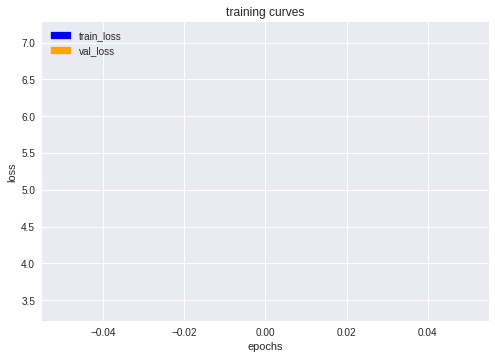

130/130 [==============================] - 111s 852ms/step - loss: 7.0489 - categorical_accuracy: 0.8731 - val_loss: 3.4054 - val_categorical_accuracy: 0.9820
Epoch 2/10
37/37 [==============================] - 10s 273ms/step - loss: 3.8836 - categorical_accuracy: 0.9820


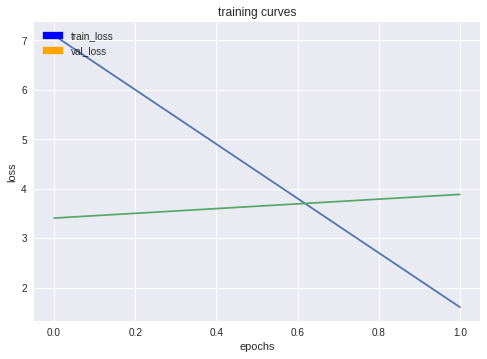

130/130 [==============================] - 102s 783ms/step - loss: 1.5994 - categorical_accuracy: 0.9851 - val_loss: 3.8836 - val_categorical_accuracy: 0.9820
Epoch 3/10
37/37 [==============================] - 10s 274ms/step - loss: 2.4391 - categorical_accuracy: 0.9828


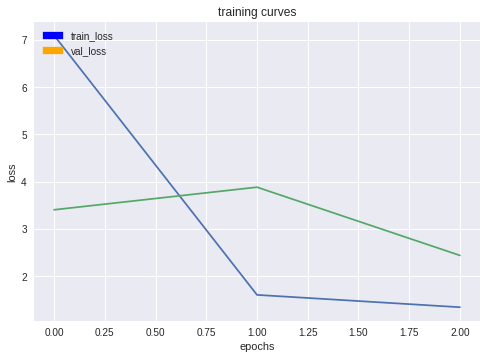

130/130 [==============================] - 102s 784ms/step - loss: 1.3341 - categorical_accuracy: 0.9878 - val_loss: 2.4391 - val_categorical_accuracy: 0.9828
Epoch 4/10
37/37 [==============================] - 10s 275ms/step - loss: 1.5231 - categorical_accuracy: 0.9876


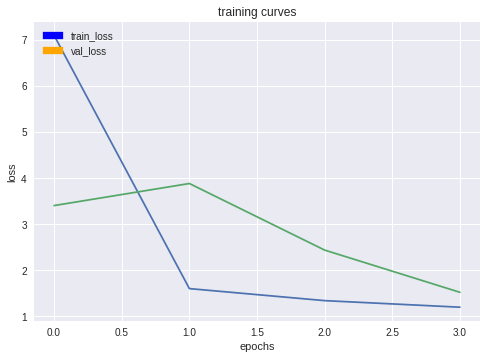

130/130 [==============================] - 101s 779ms/step - loss: 1.1917 - categorical_accuracy: 0.9882 - val_loss: 1.5231 - val_categorical_accuracy: 0.9876
Epoch 5/10
37/37 [==============================] - 10s 269ms/step - loss: 2.9970 - categorical_accuracy: 0.9642


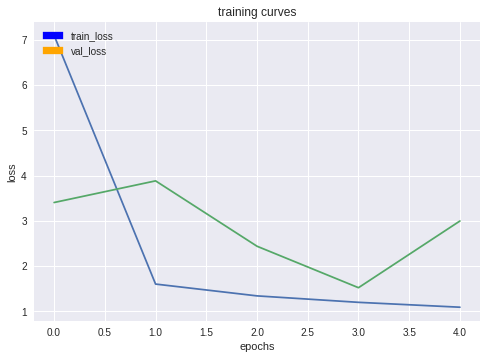

130/130 [==============================] - 102s 783ms/step - loss: 1.0993 - categorical_accuracy: 0.9897 - val_loss: 2.9970 - val_categorical_accuracy: 0.9642
Epoch 6/10
37/37 [==============================] - 10s 273ms/step - loss: 1.2780 - categorical_accuracy: 0.9891


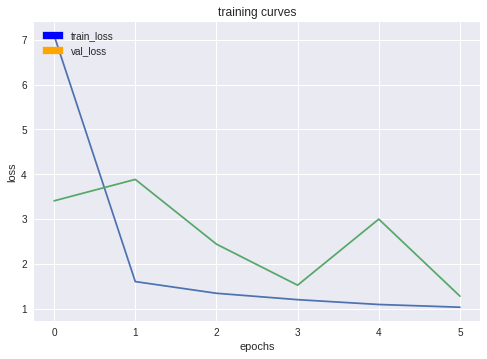

130/130 [==============================] - 100s 769ms/step - loss: 1.0250 - categorical_accuracy: 0.9900 - val_loss: 1.2780 - val_categorical_accuracy: 0.9891
Epoch 7/10
37/37 [==============================] - 10s 273ms/step - loss: 1.8626 - categorical_accuracy: 0.9827


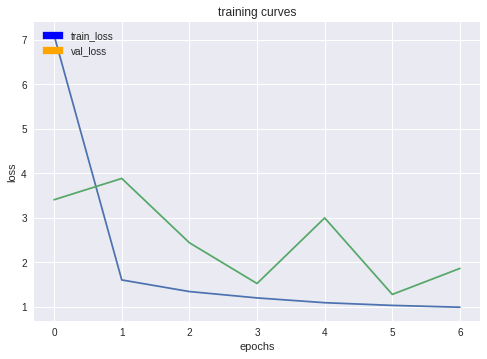

130/130 [==============================] - 102s 785ms/step - loss: 0.9846 - categorical_accuracy: 0.9906 - val_loss: 1.8626 - val_categorical_accuracy: 0.9827
Epoch 8/10
37/37 [==============================] - 10s 273ms/step - loss: 1.2959 - categorical_accuracy: 0.9889


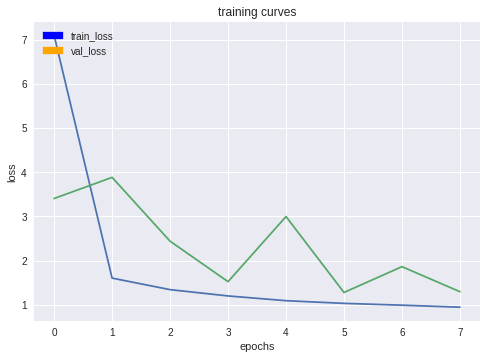

130/130 [==============================] - 101s 779ms/step - loss: 0.9388 - categorical_accuracy: 0.9908 - val_loss: 1.2959 - val_categorical_accuracy: 0.9889
Epoch 9/10
37/37 [==============================] - 10s 275ms/step - loss: 1.4391 - categorical_accuracy: 0.9865


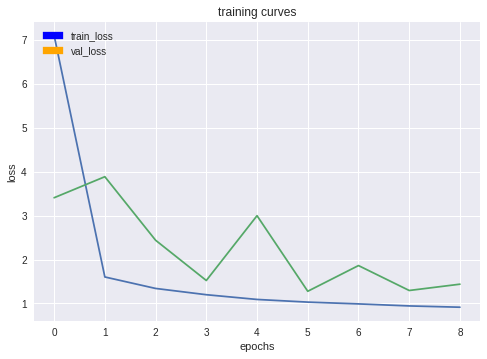

130/130 [==============================] - 102s 785ms/step - loss: 0.9097 - categorical_accuracy: 0.9915 - val_loss: 1.4391 - val_categorical_accuracy: 0.9865
Epoch 10/10
37/37 [==============================] - 10s 274ms/step - loss: 1.1780 - categorical_accuracy: 0.9902


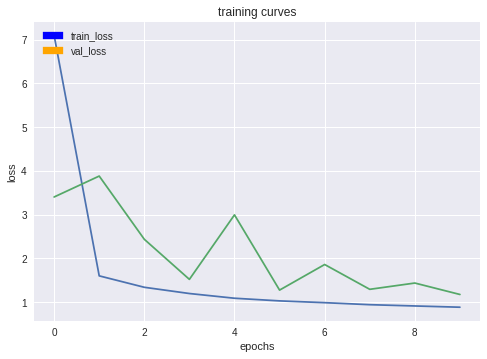

130/130 [==============================] - 100s 770ms/step - loss: 0.8820 - categorical_accuracy: 0.9913 - val_loss: 1.1780 - val_categorical_accuracy: 0.9902


In [0]:
model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks = [LoggerPlotter()],
                    workers = workers)

In [0]:
# Save weights to a TensorFlow Checkpoint file
model.save_weights('./weights/model_colab_with_default_data')

# Prediction

In [0]:
# Restore the model's state,
# this requires a model with the same architecture.
model.load_weights('./weights/model_colab_with_default_data')

In [0]:
def make_dir_if_not_exist(path):
    if not os.path.exists(path):
        os.makedirs(path)

def write_predictions_grade_set(model, out_folder_suffix,subset_name, grading_dir_name):
    validation_path = os.path.join('data', grading_dir_name, subset_name)
    file_names = sorted(glob(os.path.join(validation_path, 'images', '*.jpeg')))

    output_path = os.path.join('data', 'runs', subset_name + '_' + out_folder_suffix)
    make_dir_if_not_exist(output_path)
    image_shape = model.layers[0].output_shape[1]

    for name in file_names:
        image = imageio.imread(name)
        if image.shape[0] != image_shape:
             image = misc.imresize(image, (image_shape, image_shape, 3))
        image = preprocess_input(image.astype(np.float32))
        pred = model.predict_on_batch(np.expand_dims(image, 0))
        base_name = os.path.basename(name).split('.')[0]
        base_name = base_name + '_prediction.png'
        imageio.imwrite(os.path.join(output_path, base_name), np.squeeze((pred * 255).astype(np.uint8)))
    return validation_path, output_path

In [0]:
run_num = 'run_1'

val_with_targ, pred_with_targ = write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


In [0]:
def show(im, x=5, y=5):
    plt.figure(figsize=(x,y))
    plt.imshow(im)
    plt.show()
    
def show_images(maybe_ims, x=4, y=4):
    if isinstance(maybe_ims, (list, tuple)):
        border = np.ones((maybe_ims[0].shape[0], 10, 3))
        border = border.astype(np.uint8)
        new_im = maybe_ims[0]
        for i in maybe_ims[1:]:
            new_im = np.concatenate((new_im, border, i), axis=1)
        show(new_im, len(maybe_ims)*x, y)
    else:
        show(maybe_ims)

# helpers for loading a few images from the grading data 
def get_im_files(path, subset_name):
    return sorted(glob(os.path.join(path, subset_name, 'images', '*.jpeg')))
                  
def get_mask_files(path, subset_name):
    return sorted(glob(os.path.join(path, subset_name, 'masks', '*.png')))

def get_pred_files(subset_name):
    return sorted(glob(os.path.join('data', 'runs', subset_name, '*.png')))

def get_im_file_sample(grading_data_dir_name, subset_name, pred_dir_suffix=None, n_file_names=10):
    path = os.path.join('data', grading_data_dir_name)
    ims = np.array(get_im_files(path, subset_name)) 
    masks = np.array(get_mask_files(path, subset_name))  
    
    shuffed_inds = np.random.permutation(np.arange(masks.shape[0]))
    ims_subset = ims[shuffed_inds[:n_file_names]]
    masks_subset = masks[shuffed_inds[:n_file_names]]
    if not pred_dir_suffix:
        return list(zip(ims_subset, masks_subset))
    else:
        preds = np.array(get_pred_files(subset_name+'_'+pred_dir_suffix))
        preds_subset = preds[shuffed_inds[:n_file_names]]
        return list(zip(ims_subset, masks_subset, preds_subset))
    
def load_images(file_tuple):
    im = imageio.imread(file_tuple[0])
    mask = imageio.imread(file_tuple[1])
    if len(file_tuple) == 2:
        return im, mask
    else:
        pred = imageio.imread(file_tuple[2])
        if pred.shape[0] != im.shape[0]:
            mask = misc.imresize(mask, pred.shape)
            im = misc.imresize(im, pred.shape)
        return im, mask, pred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


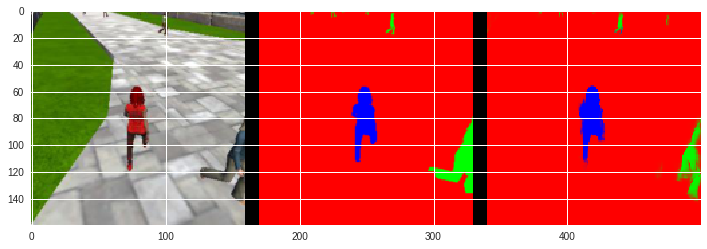

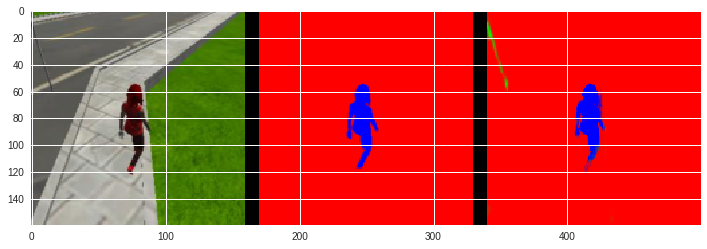

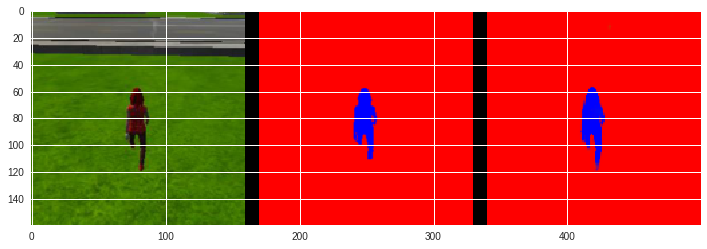

In [0]:
# images while following the target
im_files = get_im_file_sample('sample_evaluation_data','following_images', run_num)
for i in range(3):
    im_tuple = load_images(im_files[i])
    show_images(im_tuple)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


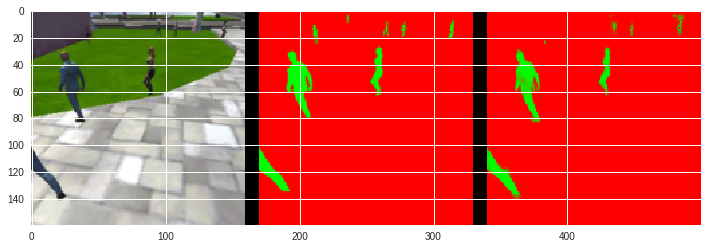

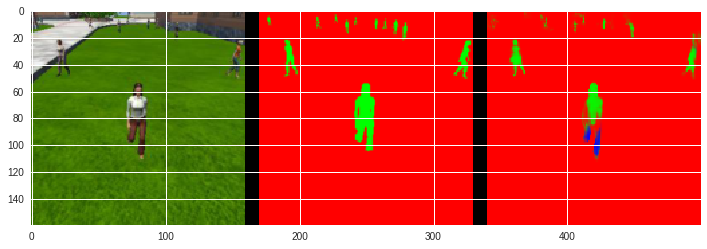

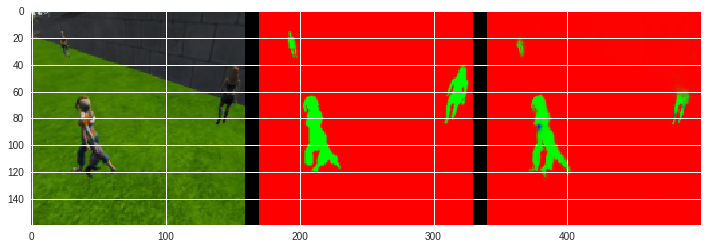

In [0]:
# images while at patrol without target
im_files = get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = load_images(im_files[i])
    show_images(im_tuple)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


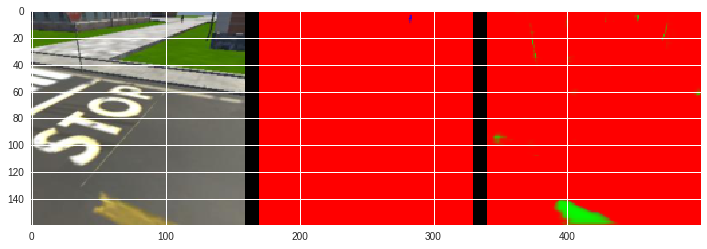

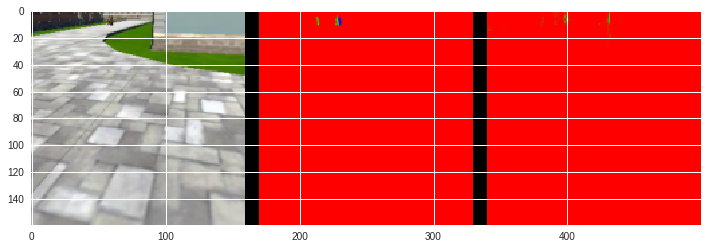

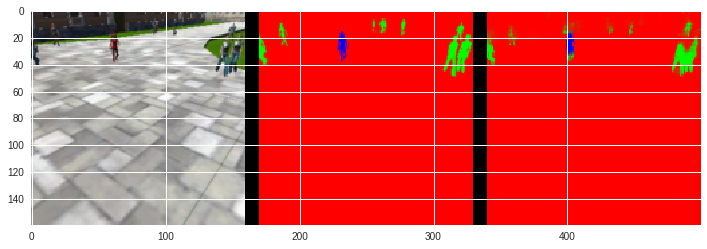

In [0]:
# images while at patrol with target
im_files = get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = load_images(im_files[i])
    show_images(im_tuple)

In [0]:
from scipy import ndimage as ndi

def intersection_over_union(y_true, y_pred):
    """Computes the intersection over union of to arrays containing 1's and 0's
    Assumes y_true has converted from real value to binary values. 
    """

    if np.sum(y_true == 1) + np.sum(y_true == 0) != y_true.shape[0]*y_true.shape[1]:
        raise ValueError('Groud truth mask must only contain values from the set {0,1}')

    if np.sum(y_pred == 1) + np.sum(y_pred == 0) != y_pred.shape[0]*y_pred.shape[1]:
        raise ValueError('Segmentation mask must only contain values from the set {0,1}')

    if y_true.ndim != 2:
        if y_true.shape[2] != 1 or y_true.shape[2] != 0:
            raise ValueError('Too many ground truth masks are present')

    if y_pred.ndim != 2:
        if y_pred.shape[2] != 1 or y_pred.shape[2] != 0:
            raise ValueError('too many segmentation masks are present')

    if y_pred.shape != y_true.shape:
        raise ValueError('The dimensions of y_true, and y_pred are not the same')

    intersection = np.sum(y_true * y_pred).astype(np.float)
    union = np.sum(np.clip(y_true + y_pred, 0, 1)).astype(np.float)

    # Alternatively we can return some small value epsilon
    if union == 0:
        # return 1e-10
        return 0

    else:
        return intersection/union # + 1e-10


def jaccard_distance(y_true, y_pred):
    return 1 - intersection_over_union(y_true, y_pred)


def average_squared_distance(y_true, y_pred):
    if y_pred.shape != y_true.shape:
        raise ValueError('The dimensions of y_true, and y_pred are not the same')

    return np.sqrt(np.sum(np.power(y_true - y_pred, 2)))


def average_squared_log_distance(y_true, y_pred):
    if y_pred.shape != y_true.shape:
        raise ValueError('The dimensions of y_true, and y_pred are not the same')
    
    dist = np.abs(y_true-y_pred) 
    return np.sqrt(np.sum(np.power(np.log1p(dist), 2)))


def get_centroid(seg_mask, slices):
    sliced = seg_mask[slices]
    ys, xs = np.where(sliced)
    
    # get the centroid coordinates in the original image
    y_cent = np.round(ys.mean()).astype(np.int) + slices[0].start
    x_cent = np.round(xs.mean()).astype(np.int) + slices[1].start
    return y_cent, x_cent


def find_largest_obj(seg_mask, objs):
    counts = list()
    for slices in objs:
        counts.append((seg_mask[slices]).sum())
    max_id = np.argmax(np.array(counts))
    largest_obj = objs[max_id]
    return largest_obj


def get_centroid_largest_blob(seg_mask):
    labeled_blobs = ndi.label(seg_mask)
    objs = ndi.find_objects(labeled_blobs[0])
    largest_obj = find_largest_obj(seg_mask, objs)
    return np.array(get_centroid(seg_mask, largest_obj))


def score_run_iou(gt_dir, pred_dir):
    gt_files = sorted(glob(os.path.join(gt_dir, 'masks', '*.png')))
    pred_files = sorted(glob(os.path.join(pred_dir, '*.png')))
    ious = [0,0,0]
    n_preds = len(gt_files)
    n_true_pos = 0 
    n_false_neg = 0
    n_false_pos = 0

    for e, gt_file in enumerate(gt_files):
        gt_mask = misc.imread(gt_file).clip(0, 1)
        pred_mask = (misc.imread(pred_files[e]) > 127).astype(np.int)

        if gt_mask.shape[0] != pred_mask.shape[0]:
            gt_mask = misc.imresize(gt_mask, pred_mask.shape)

        for i in range(3):
            ious[i] += intersection_over_union(pred_mask[:,:,i], gt_mask[:,:,i])


        if gt_mask[:,:,2].sum() > 3:
            if pred_mask[:,:, 2].sum() > 3:
                n_true_pos += 1
            else:
                n_false_neg += 1

        else:
            if pred_mask[:, :, 2].sum() > 3:
                n_false_pos += 1

    background = ious[0] / n_preds
    people = ious[1] / n_preds
    hero = ious[2] / n_preds

    print('number of validation samples intersection over the union evaulated on {}'.format(n_preds))
    print('average intersection over union for background is {}'.format(background))
    print('average intersection over union for other people is {}'.format(people))
    print('average intersection over union for the hero is {}'.format(hero))
    print('number true positives: {}, number false positives: {}, number false negatives: {}'.format(n_true_pos, n_false_pos, n_false_neg))
    return n_true_pos, n_false_pos, n_false_neg, hero


def score_run_centroid(gt_dir, pred_dir):
    gt_files = sorted(glob.glob(os.path.join(gt_dir, 'masks', '*.png')))
    pred_files = sorted(glob.glob(os.path.join(pred_dir, '*.png')))

    error1 = 0
    error2 = 0
    n_valid_detections = 0
    n_invalid_detections = 0
    n_missed = 0

    for e, gt_file in enumerate(gt_files):
        gt_mask = misc.imread(gt_file)[:, :, 1].clip(0, 1)
        pred_mask = (misc.imread(pred_files[e])[:, :, 1] > 127).astype(np.int)
        if gt_mask.shape[0] != pred_mask.shape[0]:
            gt_mask = misc.imresize(gt_mask, pred_mask.shape)

        # there target was in the image
        if gt_mask.sum() > 3:
            if pred_mask.sum() > 3:
                gt_centroid = get_centroid_largest_blob(gt_mask)
                pred_centroid = get_centroid_largest_blob(pred_mask)
                error1 += average_squared_distance(pred_centroid, gt_centroid)
                error2 += average_squared_log_distance(pred_centroid, gt_centroid)
                n_valid_detections += 1
            else:
                n_missed += 1

        # the target was not in the image
        else:
            # we got a false positive
            if pred_mask.sum() > 3:
                n_invalid_detections += 1

    n_preds = len(gt_files)
    print('total number of images evaluated on'.format(n_preds))

    print('number of true positives: {}'.format(n_valid_detections))
    print('number of false positives is: {}'.format(n_invalid_detections))
    print('number of false negatives is : {}'.format(n_missed))

    if n_valid_detections > 0:
        print('The following two metrics are only computed on examples where a valid centroid was detected')
        print('average squared pixel distance error {}'.format(error1 / n_valid_detections))
        print('average squared log pixel distance error {}'.format(error2 / n_valid_detections))

In [0]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = score_run_iou(val_following, pred_following)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9936922633057605
average intersection over union for other people is 0.3131419265461607
average intersection over union for the hero is 0.8870735623558801
number true positives: 539, number false positives: 1, number false negatives: 0


In [0]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = score_run_iou(val_no_targ, pred_no_targ)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.982500798930261
average intersection over union for other people is 0.6510057619206838
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 98, number false negatives: 0


In [0]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = score_run_iou(val_with_targ, pred_with_targ)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9954446563957439
average intersection over union for other people is 0.4005313382289202
average intersection over union for the hero is 0.268024752788294
number true positives: 150, number false positives: 5, number false negatives: 151


In [0]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.7298728813559322
0.577549157572087
0.4215374677618305
